# Human Learning for GESAR Data

## Objectives:

### Setup Code

Load Data Frame with sequences and LogDC values  
Sort Data Frame in Ascending Manner  
Plot histogram of LogDC values  
Store Top 100 and Bottom 100 Sequences  
Plot their histograms  
Descriptive statistics -> Mean, median, min, max, std  


### What are some of the most important AA in the top 100 sequences? 

Find this by seeing which AA occurs the most often in here and its frequency. 


### Is it sufficient to start with W or start somewhere else? 

### W -> Are all 8000 Sequences that start with W good?

Find sequences starting with w in data set  
Store them  
Plot their performance  
Generate Stats -> Mean, Std, Max, Min  
Store them in offline format. 

### WNFA -> What leads to the steepest drop in performance for WNFA? (1 Hamming Distance)

How: 
Write it all possible Sequences one hamming distance away from WNFA.  
Find which ones show up in our data set.  
Store and plot these sequences -> Sequence vs performance (Sorted)  
Is there an absence of these molecules in top 100 sequences?
* Search for said molecules in the top 100


## Final Objective:

Get the Best Sequence possible based on Human Learning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import random
from matplotlib.pyplot import cm
from tqdm import tqdm_notebook

In [2]:
def filter_data(dfvz):
    # Filter Includes All Samples Containing Cysteine
    filter_cys = dfvz['seq'].str.contains('C')

    # Filter Includes All Samples Containing Proline in First Position but not in Second Position
    # I.e PCEQ is included but not PPEQ
    filter_proline = dfvz['seq'].str.contains('(^P[^P])')

    # Combined Filter to select any samples that satisfy either condition!
    filter_proline_cysteine = dfvz['seq'].str.contains('(^P[^P])|([C])')

    # Create index so it can be used for both DF20 and DFVZ (inverted to remove filtered rows)
    idx_filter_inverted = dfvz[~filter_proline_cysteine].index.to_list()

    print(f'Original Data Set Samples: {len(dfvz)}\
        \nSamples Containing Cystiene Residues: {len(dfvz[filter_cys])}\
        \nSamples Containing Proline (But Not Proline-Proline) {len(dfvz[filter_proline])}\
        \nTotal Samples that satisfy either condition (Some Overlap) {len(dfvz[filter_proline_cysteine])}\
        \nFinal Samples Used: {len(idx_filter_inverted)}\
        \nPercentage Removed: {len(idx_filter_inverted)/len(dfvz):.2%}')
    
    return idx_filter_inverted

In [3]:
dfvz = pd.read_csv('../DataFiles/experimental_data_set.csv', engine='c', index_col=0)
filtered_indices = filter_data(dfvz)
# Removes all Samples Containing C and PXXX where X != P
dfvz_filtered = dfvz.loc[filtered_indices]
dfvz_filtered.sort_values(inplace=True, by=['log.label'])
dfvz_compact = dfvz_filtered.loc[:, ['seq', 'log.label']]

Original Data Set Samples: 67278        
Samples Containing Cystiene Residues: 2740        
Samples Containing Proline (But Not Proline-Proline) 4328        
Total Samples that satisfy either condition (Some Overlap) 6846        
Final Samples Used: 60432        
Percentage Removed: 89.82%


In [4]:
top_100 = dfvz_compact.iloc[-1000:]
bottom_100 = dfvz_compact.iloc[:1000]
top_100.sort_values(inplace=True, by=['log.label'], ascending=False)
bottom_100.to_csv('csv_files_explore/bottom_1000.csv')
top_100.to_csv('csv_files_explore/top_1000.csv')

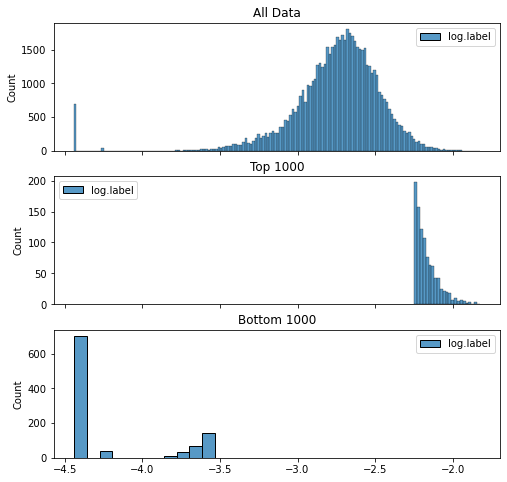

In [5]:
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(8,8))
sns.histplot(dfvz_compact, ax=axes[0])
axes[0].set_title('All Data')
sns.histplot(top_100, ax=axes[1])
axes[1].set_title('Top 1000')
sns.histplot(bottom_100, ax=axes[2])
axes[2].set_title('Bottom 1000')
axes[0].set_xlabel('Log DC Value')
plt.savefig('csv_files_explore/all_top_bot_1000_dist.png')

In [6]:
def descript_stats(dataframes):
    for df in dataframes:
        print('*'*50)
        mean = df['log.label'].mean()
        std = df['log.label'].std()
        minimum = df['log.label'].min()
        maximum = df['log.label'].max()
        print(f'{mean:.4f} +- {std:.4f}\nMin: {minimum:.4f}\nMaximum: {maximum:.4f}')

In [7]:
descript_stats([dfvz_compact, top_100, bottom_100])

**************************************************
-2.7528 +- 0.3106
Min: -4.4399
Maximum: -1.8262
**************************************************
-2.1666 +- 0.0756
Min: -2.2481
Maximum: -1.8262
**************************************************
-4.2221 +- 0.3562
Min: -4.4399
Maximum: -3.5319


In [8]:
aa = ['R','K','Q','E','D','N','Y','P','T','S','H','A','G','W','M','F','L','V','I']
aa_counter_top_1000 = {}
aa_counter_bottom_1000 = {}
aa_counter_all = {}
for a in aa:
    aa_counter_bottom_1000[a] = 0
    aa_counter_top_1000[a] = 0
    aa_counter_all[a] = 0

for seq in tqdm_notebook(bottom_100.seq.values):
    for a in aa:
        if a in seq:
            aa_counter_bottom_1000[a] += 1

for seq in tqdm_notebook(top_100.seq.values):
    for a in aa:
        if a in seq:
            aa_counter_top_1000[a] += 1

for seq in tqdm_notebook(dfvz_compact.seq.values):
    for a in aa:
        if a in seq:
            aa_counter_all[a] += 1

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/60432 [00:00<?, ?it/s]

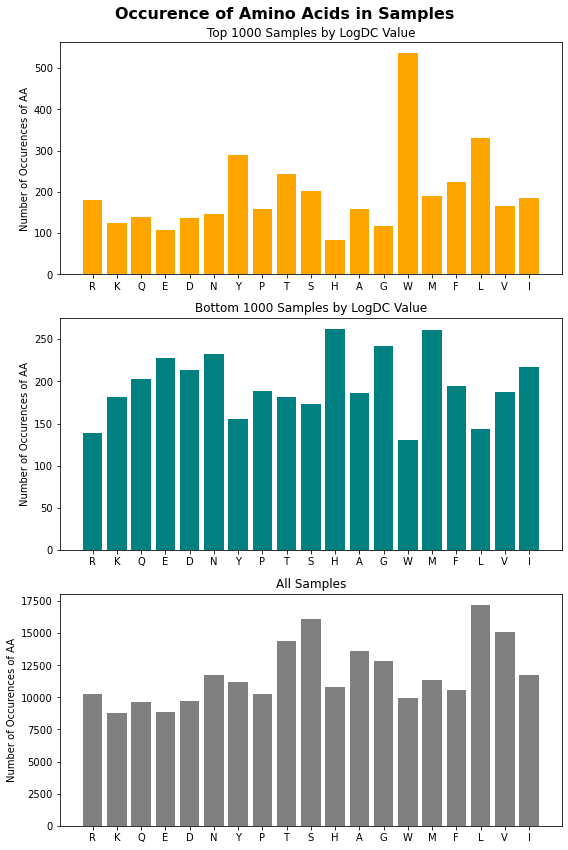

In [9]:
fig, axes = plt.subplots(3, 1, sharex=False, figsize=(8,12))

axes[0].bar(*zip(*aa_counter_top_1000.items()), color='orange')
axes[0].set_title('Top 1000 Samples by LogDC Value')
axes[0].set_ylabel('Number of Occurences of AA')
axes[1].bar(*zip(*aa_counter_bottom_1000.items()), color='teal')
axes[1].set_title('Bottom 1000 Samples by LogDC Value')
axes[1].set_ylabel('Number of Occurences of AA')
axes[2].bar(*zip(*aa_counter_all.items()), color='gray')
axes[2].set_title('All Samples')
axes[2].set_ylabel('Number of Occurences of AA')
plt.suptitle('Occurence of Amino Acids in Samples', fontsize=16, weight='bold')
plt.tight_layout()
plt.savefig('csv_files_explore/occurence_aa_plot.png')

## We can see that W is important followed by L & Y

We will do a couple of things:

1. Plot the distribution of all sequences containing W at any position
2. Plot the distribution of sequences containing w at position 1, 2, 3 and 4
3. Plot against all sequences/ top 1000 sequences

In [10]:
w_set = dfvz_compact[dfvz_compact['seq'].str.startswith('W')]
w_containing_set = dfvz_compact[dfvz_compact['seq'].str.contains('W')]
dfvz_sampled = dfvz_compact.sample(9000)

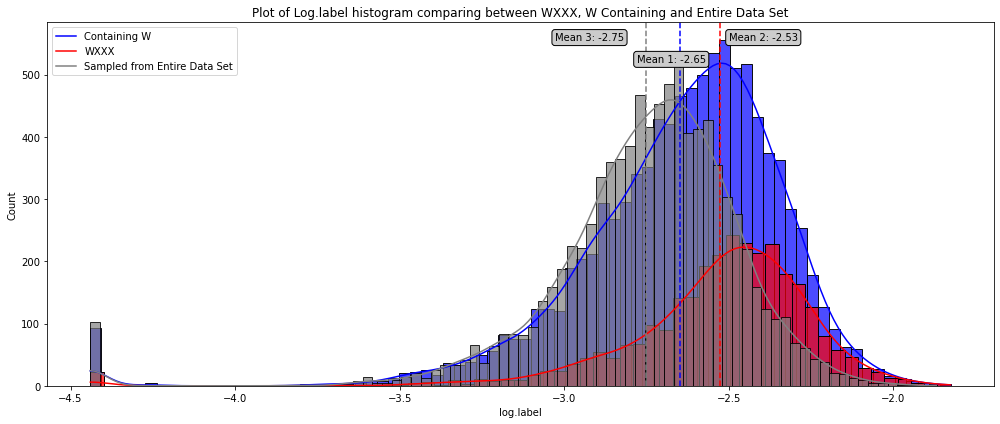

In [11]:
fig, axes = plt.subplots(1,1, figsize=(14,6))

sns.histplot(w_containing_set['log.label'], color='blue', ax=axes, alpha=0.7, kde=True)
sns.histplot(w_set['log.label'], color='red', ax=axes, alpha=0.7, kde=True)
sns.histplot(dfvz_sampled['log.label'], color='gray', ax=axes, alpha=0.7, kde=True)

min_ylim, max_ylim = plt.ylim()

bbox = dict(boxstyle="round", fc="0.8")

plt.axvline(w_containing_set['log.label'].mean(), axes=axes, color='blue', linestyle='dashed')
plt.text(w_containing_set['log.label'].mean()*1.05, max_ylim*0.89, f'Mean 1: {w_containing_set["log.label"].mean():0.2f}', bbox=bbox)

plt.axvline(w_set['log.label'].mean(), axes=axes, color='red', linestyle='dashed')
plt.text(w_set['log.label'].mean()*0.99, max_ylim*0.95, f'Mean 2: {w_set["log.label"].mean():0.2f}', bbox=bbox)

plt.axvline(dfvz_sampled['log.label'].mean(), axes=axes, color='gray', linestyle='dashed')
plt.text(dfvz_sampled['log.label'].mean()*1.1, max_ylim*0.95, f'Mean 3: {dfvz_sampled["log.label"].mean():0.2f}', bbox=bbox)

plt.legend(labels=['Containing W','WXXX', 'Sampled from Entire Data Set'], loc='upper left')
plt.title('Plot of Log.label histogram comparing between WXXX, W Containing and Entire Data Set')
plt.tight_layout()
plt.savefig('w-plots-logdc.png')

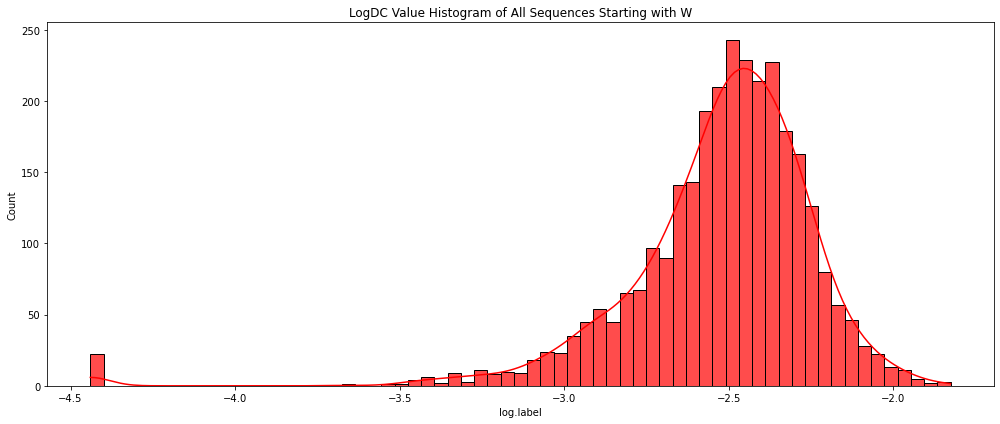

In [12]:
fig, axes = plt.subplots(1,1, figsize=(14,6))
sns.histplot(w_set['log.label'], color='red', alpha=0.7, kde=True, ax=axes)
plt.title('LogDC Value Histogram of All Sequences Starting with W')
plt.tight_layout()
plt.savefig('logdc-hist-starting-with-w.png')

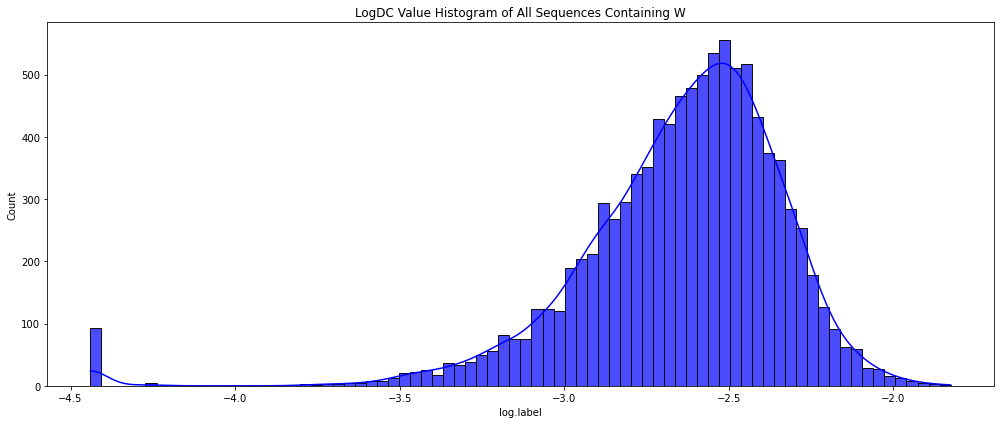

In [13]:
fig, axes = plt.subplots(1,1, figsize=(14,6))
sns.histplot(w_containing_set['log.label'], color='blue', alpha=0.7, kde=True, ax=axes)
plt.title('LogDC Value Histogram of All Sequences Containing W')
plt.tight_layout()
plt.savefig('logdc-hist-containing-with-w.png')

In [14]:
w_set['log.label'].mean()

-2.5255903764562535

  0%|          | 0/9925 [00:00<?, ?it/s]

  0%|          | 0/2985 [00:00<?, ?it/s]

  0%|          | 0/9000 [00:00<?, ?it/s]

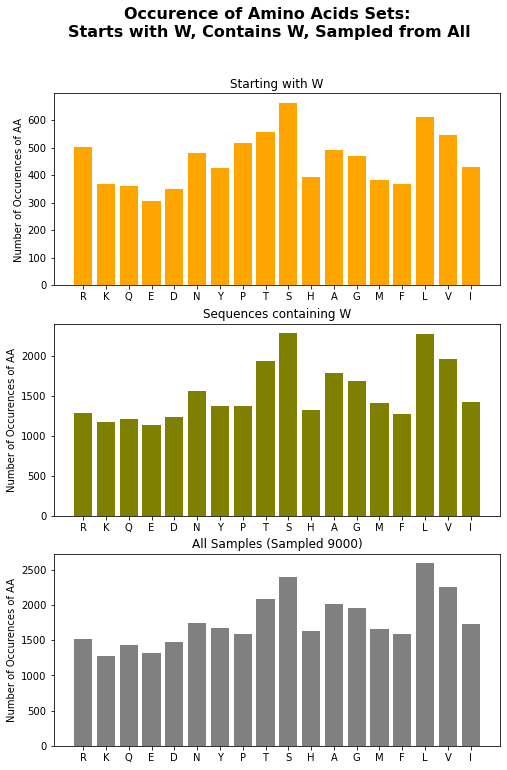

In [15]:
aa = ['R','K','Q','E','D','N','Y','P','T','S','H','A','G','M','F','L','V','I']
aa_counter_w_starts = {}
aa_counter_w_contains = {}
aa_counter_sampled = {}
for a in aa:
    aa_counter_w_starts[a] = 0
    aa_counter_w_contains[a] = 0
    aa_counter_sampled[a] = 0

for seq in tqdm_notebook(w_containing_set.seq.values):
    for a in aa:
        if a in seq:
            aa_counter_w_contains[a] += 1

for seq in tqdm_notebook(w_set.seq.values):
    for a in aa:
        if a in seq:
            aa_counter_w_starts[a] += 1

for seq in tqdm_notebook(dfvz_sampled.seq.values):
    for a in aa:
        if a in seq:
            aa_counter_sampled[a] += 1

fig, axes = plt.subplots(3, 1, sharex=False, figsize=(8,12))
axes[0].bar(*zip(*aa_counter_w_starts.items()), color='orange')
axes[0].set_title('Starting with W')
axes[0].set_ylabel('Number of Occurences of AA')
axes[1].bar(*zip(*aa_counter_w_contains.items()), color='olive')
axes[1].set_title('Sequences containing W')
axes[1].set_ylabel('Number of Occurences of AA')
axes[2].bar(*zip(*aa_counter_sampled.items()), color='gray')
axes[2].set_title('All Samples (Sampled 9000)')
axes[2].set_ylabel('Number of Occurences of AA')
plt.suptitle('Occurence of Amino Acids Sets: \nStarts with W, Contains W, Sampled from All', fontsize=16, weight='bold')
# plt.tight_layout()
plt.savefig('csv_files_explore/occurence_aa_w_plot.png')

## Distribution of AA within the Slowest Performing Ws

Distribution of AA within all below -4.0

In [16]:
w_starts_with_less_neg4 = w_set[w_set['log.label'] <= -4.0]
w_contains_less_neg4 = w_containing_set[w_containing_set['log.label'] <= -4.0]

In [17]:

w_contains_high = w_containing_set[w_containing_set['log.label'] >= -2.0]

In [18]:
aa_counter([w_contains_high], ['W-High'])

NameError: name 'aa_counter' is not defined

In [16]:
w_contains_less_neg4

,seq,log.label
66493,MFWI,-4.439897
66498,NFWS,-4.439897
66481,GEGW,-4.439897
66938,NRTW,-4.439897
66479,FMIW,-4.439897
...,...,...
67237,AFWD,-4.263806
67273,VWVL,-4.263806
67192,IDIW,-4.263806
67260,IIWD,-4.263806


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

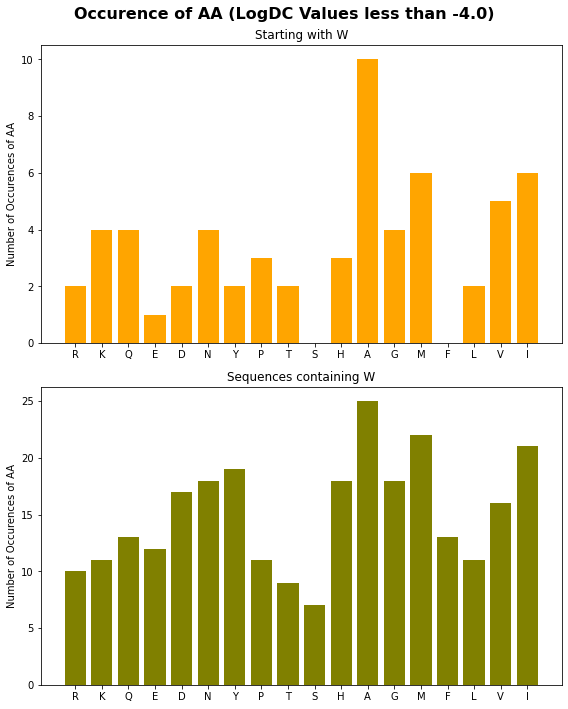

In [17]:
aa = ['R','K','Q','E','D','N','Y','P','T','S','H','A','G','M','F','L','V','I']
aa_counter_w_starts_neg4 = {}
aa_counter_w_contains_neg4 = {}
for a in aa:
    aa_counter_w_starts_neg4[a] = 0
    aa_counter_w_contains_neg4[a] = 0

for seq in tqdm_notebook(w_starts_with_less_neg4.seq.values):
    for a in aa:
        if a in seq:
            aa_counter_w_starts_neg4[a] += 1

for seq in tqdm_notebook(w_contains_less_neg4.seq.values):
    for a in aa:
        if a in seq:
            aa_counter_w_contains_neg4[a] += 1

fig, axes = plt.subplots(2, 1, sharex=False, figsize=(8,10))
axes[0].bar(*zip(*aa_counter_w_starts_neg4.items()), color='orange')
axes[0].set_title('Starting with W')
axes[0].set_ylabel('Number of Occurences of AA')
axes[1].bar(*zip(*aa_counter_w_contains_neg4.items()), color='olive')
axes[1].set_title('Sequences containing W')
axes[1].set_ylabel('Number of Occurences of AA')
plt.suptitle('Occurence of AA (LogDC Values less than -4.0)', fontsize=16, weight='bold')
plt.tight_layout()
plt.savefig('csv_files_explore/occurence_aa_w_slow_plot.png')

In [19]:
def aa_counter(dfs, captions, colors = ['orange', 'olive', 'gray']):
    num_df = len(dfs)
    fig, axes = plt.subplots(num_df, 1, figsize=(8,6*num_df))
    aa = ['R','K','Q','E','D','N','Y','P','T','S','H','A','G','M','F','L','V','I']

    color = colors
    for n,df in enumerate(dfs):
        aa_counter = dict(zip(aa, (0 for _ in aa)))

        for seq in df.seq.values:
            for a in aa:
                if a in seq:
                    aa_counter[a] += 1

        if len(dfs) == 1:
            axes.bar(*zip(*aa_counter.items()), color=color[n])
            axes.set_ylabel('Number of Occurences of AA')
            axes.set_title(captions[n])

        else:
            axes[n].bar(*zip(*aa_counter.items()), color=color[n])
            axes[n].set_ylabel('Number of Occurences of AA')
            axes[n].set_title(captions[n])

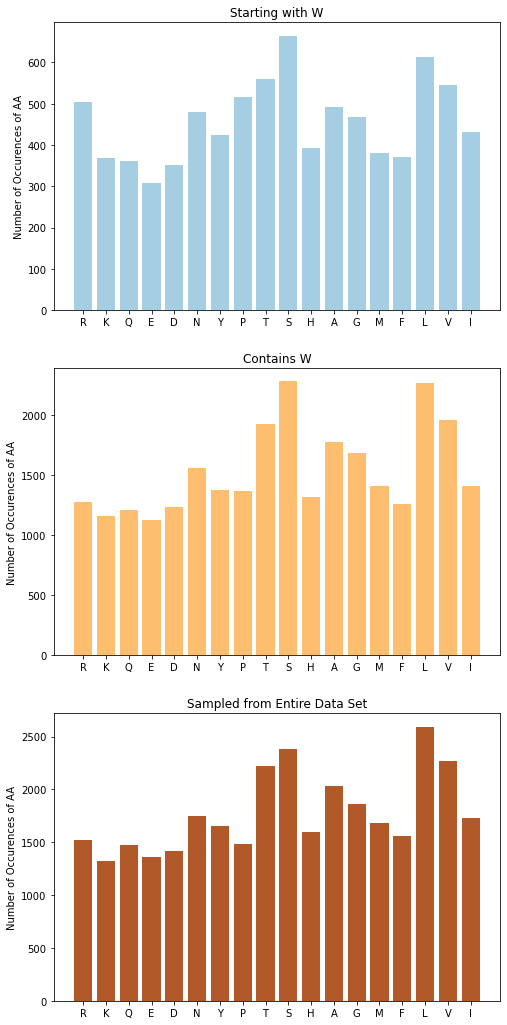

In [19]:
aa_counter([w_set, w_containing_set, dfvz_sampled], \
    ['Starting with W', 'Contains W', 'Sampled from Entire Data Set'])

### WNFA -> What leads to the steepest drop in performance for WNFA? (1 Hamming Distance)

How: 
Write it all possible Sequences one hamming distance away from WNFA.  
Find which ones show up in our data set.  
Store and plot these sequences -> Sequence vs performance (Sorted)  
Is there an absence of these molecules in top 100 sequences?
* Search for said molecules in the top 100


In [20]:
def hamming_seqs(seq, aa = ['R','K','Q','E','D','N','Y','P','T','S','H','A','G','M','F','L','V','I','W']):
    seq_default = list(seq)
    seq_list_hamming_distance_away = [seq_default]

    for pos, a_acid_seq in enumerate(seq_default):
        for a in aa:
            if a != a_acid_seq:
                seq_new = seq_default.copy()
                seq_new[pos] = a
                seq_list_hamming_distance_away.append(seq_new)

    seq_list_combined = [''.join(x) for x in seq_list_hamming_distance_away]
    return seq_list_combined

In [21]:
seqs_1_ham_WNFA = hamming_seqs('WNFA')

In [22]:
wnfa_df = dfvz_compact[dfvz_compact['seq'].isin(seqs_1_ham_WNFA)]

In [23]:
len(wnfa_df)

38

In [25]:
wnfa_df.to_csv('wnfa-hamming-sequences.csv')

In [24]:
third_pos_f = dfvz_compact[dfvz_compact['seq'].str.match(r'([A-Za-z]{2}[F][a-zA-Z])') ]

<AxesSubplot:ylabel='Count'>

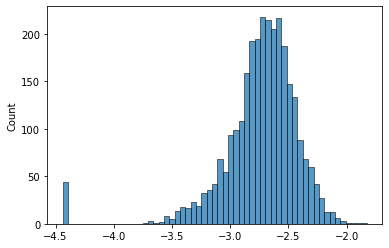

In [25]:
sns.histplot(third_pos_f['log.label'].values)

<AxesSubplot:ylabel='Count'>

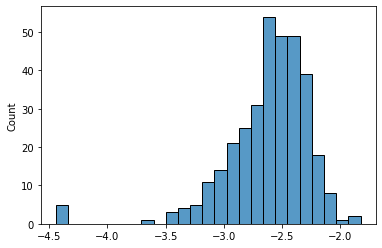

In [26]:
sns.histplot(third_pos_f[third_pos_f['seq'].str.contains('W')]['log.label'].values)

In [45]:
w_containing_set[(w_containing_set['seq'].str.contains('S')) & (w_containing_set['seq'].str.contains('F'))]

,seq,log.label
66498,NFWS,-4.439897
42395,FIWS,-3.693693
6981,WSFM,-3.454106
11747,FLWS,-3.439162
7444,HWSF,-3.341784
...,...,...
32156,FWST,-2.029228
47405,WFSP,-2.015590
50252,WFIS,-2.003120
62309,WFSN,-1.987234
